### Connect to the database

In [1]:
import sqlite3
conn = sqlite3.connect('../max-experiments/itinerary-scraping/journeys.db')
cursor = conn.cursor()

In [2]:
cursor.execute('SELECT * FROM outages')
outages = cursor.fetchall()

cursor.execute('SELECT * FROM journeys')
journeys = cursor.fetchall()

# number of outages
print(len(outages))

# frequency of outages
from collections import Counter
outage_freq = Counter([outage[1] for outage in outages])
print(outage_freq)

print('---')
print("% of journeys with outages:", round(len(outages)/len(journeys) * 100, 3))

183
Counter({'stop_point:tcl:SP:46024': 8, 'stop_point:tcl:SP:30205': 5, 'stop_point:tcl:SP:46051': 5, 'stop_point:tcl:SP:46033': 5, 'stop_point:tcl:SP:46036': 4, 'stop_point:tcl:SP:48137': 4, 'stop_point:tcl:SP:30209': 4, 'stop_point:tcl:SP:30189': 4, 'stop_point:tcl:SP:30197': 4, 'stop_point:tcl:SP:46058': 4, 'stop_point:tcl:SP:30445': 4, 'stop_point:tcl:SP:30211': 4, 'stop_point:tcl:SP:30156': 3, 'stop_point:tcl:SP:46053': 3, 'stop_point:tcl:SP:46054': 3, 'stop_point:tcl:SP:46026': 3, 'stop_point:tcl:SP:46028': 3, 'stop_point:tcl:SP:30448': 3, 'stop_point:tcl:SP:30198': 3, 'stop_point:tcl:SP:30200': 3, 'stop_point:tcl:SP:30208': 3, 'stop_point:tcl:SP:46060': 3, 'stop_point:tcl:SP:46025': 3, 'stop_point:tcl:SP:42744': 3, 'stop_point:tcl:SP:42738': 3, 'stop_point:tcl:SP:30185': 3, 'stop_point:tcl:SP:36394': 3, 'stop_point:tcl:SP:30191': 3, 'stop_point:tcl:SP:30199': 3, 'stop_point:tcl:SP:30103': 3, 'stop_point:tcl:SP:30447': 3, 'stop_point:tcl:SP:30210': 3, 'stop_point:tcl:SP:46031': 

C:\Users\Alden\AppData\Local\Temp\ipykernel_8588\1501730761.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45)


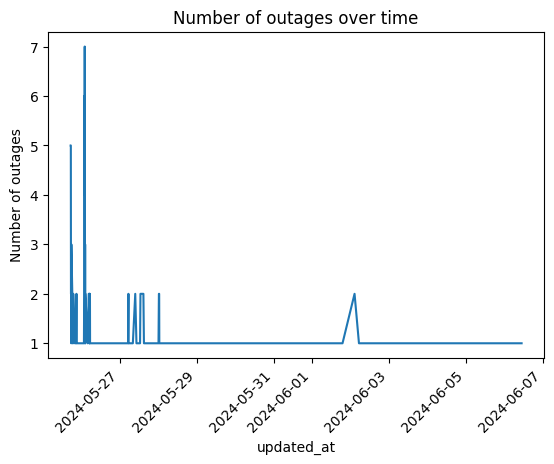

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

outages_df = pd.DataFrame(outages, columns=['outage_id', 'stop_id', 'effect', 'updated_at', 'outage_data'])

outages_df['updated_at'] = pd.to_datetime(outages_df['updated_at'])
outages_df['date'] = outages_df['updated_at'].dt.date

# plot number of outages over time
p = outages_df.groupby('updated_at').size().plot()
p.set_xticklabels(p.get_xticklabels(), rotation=45)
p.set_title('Number of outages over time')
p.set_ylabel('Number of outages')
plt.show()

In [4]:
# average length of outages
durations = []
for row in outages_df['outage_data']:
    row = row.split('begin')[1]
    
    # format is now ": "20240525T000000", "end": "20240525T193000"}]}
    # we want to extract the two dates and calculate the difference
    row = row[4:]   # cut off the first ": "
    
    # begin is the next 15 characters
    begin = row[:15]
    row = row[26:]      # cut to the end date
    
    # end is the next 15 characters
    end = row[:15]
    
    # calculate the difference
    begin = pd.to_datetime(begin)
    end = pd.to_datetime(end)
    
    # convert to seconds
    duration = (end - begin).total_seconds()
    durations.append(duration)
    
print('Average outage duration:', round(sum(durations)/len(durations), 3), 'seconds')
print('Median outage duration:', pd.Series(durations).median(), 'seconds')
print('----------')

q1 = pd.Series(durations).quantile(0.25)
q3 = pd.Series(durations).quantile(0.75)
iqr = q3 - q1

# remove outliers
durations_no_outliers = [duration for duration in durations if duration < q3 + 1.5*iqr]
print('Average outage duration (no outliers):', round(sum(durations_no_outliers)/len(durations_no_outliers), 3), 'seconds')
print('Median outage duration (no outliers):', pd.Series(durations_no_outliers).median(), 'seconds')

outages_df['duration'] = durations # add duration to the dataframe

Average outage duration: 469131.148 seconds
Median outage duration: 30600.0 seconds
----------
Average outage duration (no outliers): 42197.605 seconds
Median outage duration (no outliers): 27000.0 seconds


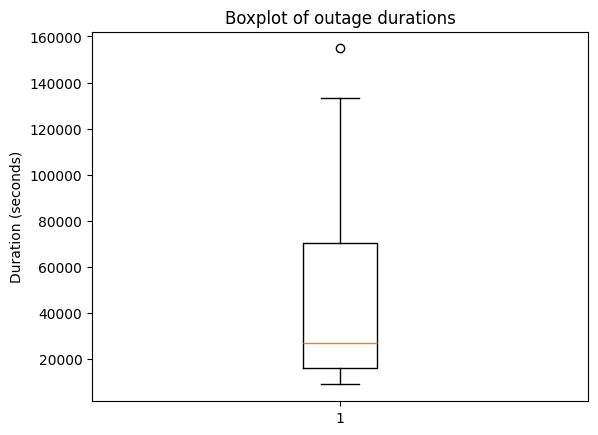

In [5]:
# boxplot of outage durations
plt.boxplot(durations_no_outliers)
plt.title('Boxplot of outage durations')
plt.ylabel('Duration (seconds)')
plt.show()

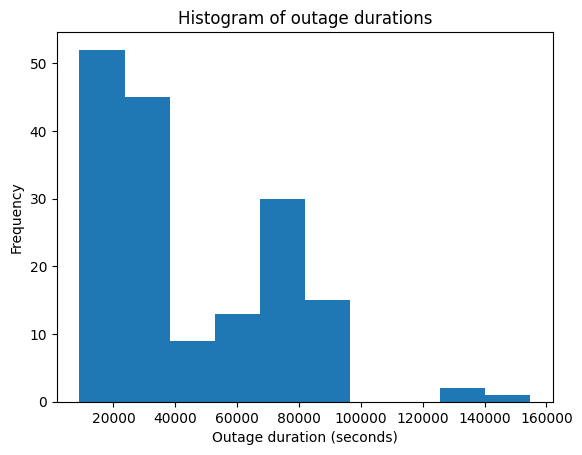

In [6]:
# histogram of outage durations
pd.Series(durations_no_outliers).hist(bins=10)
plt.title('Histogram of outage durations')
plt.xlabel('Outage duration (seconds)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [7]:
# map outages to stops
cursor.execute('SELECT * FROM stops')
stops = cursor.fetchall()

stops_df = pd.DataFrame(stops, columns=['stop_id', 'stop_name', 'stop_coords', 'stop_acc'])  
stops_df

# merge outages_df with stops_df
merged_df = pd.merge(outages_df, stops_df, on='stop_id')


In [8]:
merged_df

,outage_id,stop_id,effect,updated_at,outage_data,date,duration,stop_name,stop_coords,stop_acc
0,828,stop_point:tcl:SP:30205,unavailable,2024-05-25 17:28:00+02:00,"{""cause"": {""label"": ""Acc\u00e8s ferm\u00e9 pou...",2024-05-25,70200.0,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
1,8201,stop_point:tcl:SP:30205,unavailable,2024-05-26 05:33:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-26,27000.0,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
2,822,stop_point:tcl:SP:30205,unavailable,2024-05-29 05:08:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-29,27000.0,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
3,8202,stop_point:tcl:SP:30205,unavailable,2024-06-04 05:08:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-06-04,27000.0,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
4,8203,stop_point:tcl:SP:30205,unavailable,2024-06-04 08:38:00+02:00,"{""cause"": {""label"": ""Vandalisme""}, ""effect"": {...",2024-06-04,37800.0,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
...,...,...,...,...,...,...,...,...,...,...
178,7301,stop_point:tcl:SP:30187,unavailable,2024-05-29 17:53:00+02:00,"{""cause"": {""label"": ""Vandalisme""}, ""effect"": {...",2024-05-29,72000.0,Laennec,"{""lon"": ""4.886328"", ""lat"": ""45.738716""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
179,241,stop_point:tcl:SP:42743,unavailable,2024-05-31 05:08:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-31,25200.0,Hôtel de Ville L. Pradel,"{""lon"": ""4.836091"", ""lat"": ""45.767309""}","[""has_wheelchair_boarding""]"
180,7601,stop_point:tcl:SP:30194,unavailable,2024-05-31 05:18:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-31,27000.0,Sans Souci,"{""lon"": ""4.864748"", ""lat"": ""45.747747""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."
181,761,stop_point:tcl:SP:30194,unavailable,2024-06-02 02:28:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-06-02,16200.0,Sans Souci,"{""lon"": ""4.864748"", ""lat"": ""45.747747""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h..."


In [9]:
# extract coordinates from stop_coords
merged_df['lon'] = merged_df['stop_coords'].apply(lambda x: x.split(',')[0][9:-1])
merged_df['lat'] = merged_df['stop_coords'].apply(lambda x: x.split(',')[1][9:-2])
merged_df

,outage_id,stop_id,effect,updated_at,outage_data,date,duration,stop_name,stop_coords,stop_acc,lon,lat
0,828,stop_point:tcl:SP:30205,unavailable,2024-05-25 17:28:00+02:00,"{""cause"": {""label"": ""Acc\u00e8s ferm\u00e9 pou...",2024-05-25,70200.0,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h...",4.805544,45.766428
1,8201,stop_point:tcl:SP:30205,unavailable,2024-05-26 05:33:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-26,27000.0,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h...",4.805544,45.766428
2,822,stop_point:tcl:SP:30205,unavailable,2024-05-29 05:08:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-29,27000.0,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h...",4.805544,45.766428
3,8202,stop_point:tcl:SP:30205,unavailable,2024-06-04 05:08:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-06-04,27000.0,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h...",4.805544,45.766428
4,8203,stop_point:tcl:SP:30205,unavailable,2024-06-04 08:38:00+02:00,"{""cause"": {""label"": ""Vandalisme""}, ""effect"": {...",2024-06-04,37800.0,Gorge de Loup,"{""lon"": ""4.805544"", ""lat"": ""45.766428""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h...",4.805544,45.766428
...,...,...,...,...,...,...,...,...,...,...,...,...
178,7301,stop_point:tcl:SP:30187,unavailable,2024-05-29 17:53:00+02:00,"{""cause"": {""label"": ""Vandalisme""}, ""effect"": {...",2024-05-29,72000.0,Laennec,"{""lon"": ""4.886328"", ""lat"": ""45.738716""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h...",4.886328,45.738716
179,241,stop_point:tcl:SP:42743,unavailable,2024-05-31 05:08:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-31,25200.0,Hôtel de Ville L. Pradel,"{""lon"": ""4.836091"", ""lat"": ""45.767309""}","[""has_wheelchair_boarding""]",4.836091,45.767309
180,7601,stop_point:tcl:SP:30194,unavailable,2024-05-31 05:18:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-31,27000.0,Sans Souci,"{""lon"": ""4.864748"", ""lat"": ""45.747747""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h...",4.864748,45.747747
181,761,stop_point:tcl:SP:30194,unavailable,2024-06-02 02:28:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-06-02,16200.0,Sans Souci,"{""lon"": ""4.864748"", ""lat"": ""45.747747""}","[""has_wheelchair_boarding"", ""has_elevator"", ""h...",4.864748,45.747747


In [10]:
# plot outages on a map
import folium
from folium.plugins import MarkerCluster

m = folium.Map(location=[45.75, 4.85], zoom_start=13)

marker_cluster = MarkerCluster().add_to(m)

for idx, row in merged_df.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['outage_id']).add_to(marker_cluster)
    
m.save('out/outages/outages_map.html')

In [11]:
# plot outages on a heatmap
from folium.plugins import HeatMap

m = folium.Map(location=[45.75, 4.85], zoom_start=13)

heat_data = [[row['lat'], row['lon']] for idx, row in merged_df.iterrows()]

HeatMap(heat_data).add_to(m)

# add markers at same density as heatmap
marker_cluster = MarkerCluster().add_to(m)

for idx, row in merged_df.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['outage_id']).add_to(marker_cluster)
    
m.save('out/outages/outages_heatmap.html')